## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

In [2]:
# Load in the persons PUMS dataset for WA state
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose PUMS and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data = h_df[['HINCP','NP','VEH','BLD','ACCESS']]
# pums_data = h_df[['HINCP','NP','VEH']]

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=164836 pre-cleaning
Dataset n=140586 post-cleaning


In [4]:
CAT_IDX = 1
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX, VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [5]:
# Final data frame after encoding OHE
model_data_df = pums_data.iloc[:,:CAT_IDX]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,HINCP,NP__1,NP__2,NP__3,NP__4,NP__5,NP__6,NP__7,NP__8,NP__9,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
0,102200.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,69360.0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,210500.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,50310.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,31200.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161771,141370.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161772,60000.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161774,55000.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161775,102000.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.98)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

# Standardize the input data from -1 to 1 for numerical variables
scaler_train = skpre.MinMaxScaler()
scaler_test = skpre.MinMaxScaler()

# Separate the scaling for train/test so that no overall mean/std info is carried
train_data[:,:CAT_IDX] = scaler_train.fit_transform(train_data[:,:CAT_IDX])
test_data[:,:CAT_IDX] = scaler_test.fit_transform(test_data[:,:CAT_IDX])

## Set Parameters and Define Model

In [7]:
# Hyperparameters
BATCH_SIZE = 512
EPOCHS = 100
LATENT_DIM = 2
HIDDEN_DIM = 16
KL_WEIGHT = .04

# Best results so far:
# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 2
# HIDDEN_DIM = 64
# KL_WEIGHT = .04
# All tanh
# Adam

# Test data starts really looking good around KLLW = 0.01, Synthesis around KLLW = 0.04
# Lower KLLW gives better reconstruction on the test data
# Too low KLLW gives nonsense in the reconstruction
# Get KLLW as low as possible before reconstruction suffers

In [8]:
# A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# Takes manifest variables; outputs mean/logvar for each latent distribution
def create_encoder():
    # Encoder
    encoder_inputs = keras.Input(shape=(MANIFEST_DIM,))
    encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_inputs)
    encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_x)
    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(encoder_x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(encoder_x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder
encoder = create_encoder()
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 39)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           640         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          dense_1[0][0]                    
____________________________________________________________________________________________

In [10]:
# Takes value for each latent variable; outputs the manifest variables
def create_decoder():
    # Decoder
    decoder_inputs = keras.Input(shape=(LATENT_DIM,))
    decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_inputs)
    decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_x)
    decoder_num_outputs = layers.Dense(CAT_IDX, activation="tanh")(decoder_x)
    decoder_cat_outputs = []
    for var_length in CAT_LENGTHS:
        layer = layers.Dense(var_length, activation="softmax")(decoder_x)
        decoder_cat_outputs.append(layer)
    decoder = keras.Model(decoder_inputs, [decoder_num_outputs, decoder_cat_outputs], name="decoder")
    return decoder
decoder = create_decoder()
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           48          input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           272         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            17          dense_3[0][0]                    
____________________________________________________________________________________________

In [11]:
# Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(data, reconstruction, CAT_IDX, CAT_LENGTHS):
    # Handle case with no categorical variables
    if len(CAT_LENGTHS) > 0:
        reconstruction_num = reconstruction[0]
    else:
        reconstruction_num = reconstruction

    # Mean squared error for numerical variables
    data_num = data[:,:CAT_IDX]
    loss_num = keras.losses.mean_squared_error(data_num, reconstruction_num)
    loss_num = tf.reduce_sum(loss_num)  # Add the avg losses for each variable in current epoch
    
    # Categorical cross entropy for categorical variables
    loss_list = []
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        data_cat = data[:,current:(current + x)]
        reconstruction_cat = reconstruction[1][i]
        loss = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat, from_logits=False)
        loss = tf.reduce_mean(loss)  # Average the loss over the batch for current variable
        loss_list.append(loss)
        current += x
    loss_cat = tf.reduce_sum(loss_list)  # Add the avg losses for each variable in current epoch

    # Return both losses; they are combined in the model
    return (loss_num, loss_cat)

In [12]:
# Loss metric recorder
tot_loss_tracker = keras.metrics.Mean(name="tot_loss")
rec_loss_tracker = keras.metrics.Mean(name="rec_loss")
kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, CAT_IDX, CAT_LENGTHS, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.CAT_IDX = CAT_IDX
        self.CAT_LENGTHS = CAT_LENGTHS
        self.tot_loss_tracker = tot_loss_tracker
        self.rec_loss_tracker = rec_loss_tracker
        self.kl_loss_tracker = kl_loss_tracker

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Get latent vars from the encoder; feed to decoder and get sampled manifest variables
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)

            # Get loss between input values and reconstruction
            loss_num, loss_cat = get_reconstruction_loss(
                data,
                reconstruction,
                self.CAT_IDX,
                self.CAT_LENGTHS
            )
            reconstruction_loss = loss_num + loss_cat

            # Get Kullback Leidler loss between normal distribution and actual for latent variables
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = KL_WEIGHT * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # Combine into single loss term
            tot_loss = reconstruction_loss + kl_loss

        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(tot_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Record the loss metrics
        self.tot_loss_tracker.update_state(tot_loss)
        self.rec_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "tot_loss": self.tot_loss_tracker.result(),
            "rec_loss": self.rec_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        return [self.tot_loss_tracker, self.rec_loss_tracker, self.kl_loss_tracker]

## Training

In [13]:
start_time = time.time()

In [14]:
# Train
encoder = create_encoder()
decoder = create_decoder()
vae = VAE(encoder, decoder, CAT_IDX, CAT_LENGTHS)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
270/270 [==============================] - 1s 2ms/step - tot_loss: 7.5313 - rec_loss: 7.4627 - kl_loss: 0.0686
Epoch 2/100
270/270 [==============================] - 1s 2ms/step - tot_loss: 4.9702 - rec_loss: 4.8364 - kl_loss: 0.1337
Epoch 3/100
270/270 [==============================] - 1s 2ms/step - tot_loss: 4.3701 - rec_loss: 4.2111 - kl_loss: 0.1590
Epoch 4/100
270/270 [==============================] - 1s 2ms/step - tot_loss: 4.0256 - rec_loss: 3.8665 - kl_loss: 0.1591
Epoch 5/100
270/270 [==============================] - 0s 2ms/step - tot_loss: 3.5499 - rec_loss: 3.3790 - kl_loss: 0.1708
Epoch 6/100
270/270 [==============================] - 0s 2ms/step - tot_loss: 3.4179 - rec_loss: 3.2355 - kl_loss: 0.1825
Epoch 7/100
270/270 [==============================] - 0s 2ms/step - tot_loss: 3.3229 - rec_loss: 3.1346 - kl_loss: 0.1883
Epoch 8/100
270/270 [==============================] - 0s 2ms/step - tot_loss: 3.2374 - rec_loss: 3.0451 - kl_loss: 0.1923
Epoch 9/100
270/

270/270 [==============================] - 1s 2ms/step - tot_loss: 1.5266 - rec_loss: 1.2497 - kl_loss: 0.2769
Epoch 68/100
270/270 [==============================] - 1s 2ms/step - tot_loss: 1.5185 - rec_loss: 1.2417 - kl_loss: 0.2769
Epoch 69/100
270/270 [==============================] - 1s 2ms/step - tot_loss: 1.5089 - rec_loss: 1.2314 - kl_loss: 0.2775
Epoch 70/100
270/270 [==============================] - 1s 2ms/step - tot_loss: 1.5004 - rec_loss: 1.2223 - kl_loss: 0.2781
Epoch 71/100
270/270 [==============================] - 1s 2ms/step - tot_loss: 1.4913 - rec_loss: 1.2133 - kl_loss: 0.2781
Epoch 72/100
270/270 [==============================] - 0s 2ms/step - tot_loss: 1.4830 - rec_loss: 1.2044 - kl_loss: 0.2787
Epoch 73/100
270/270 [==============================] - 0s 2ms/step - tot_loss: 1.4741 - rec_loss: 1.1957 - kl_loss: 0.2784
Epoch 74/100
270/270 [==============================] - 0s 2ms/step - tot_loss: 1.4661 - rec_loss: 1.1871 - kl_loss: 0.2790
Epoch 75/100
270/270 

In [15]:
print(f"--- {time.time() - start_time} seconds ---")

--- 53.36359715461731 seconds ---


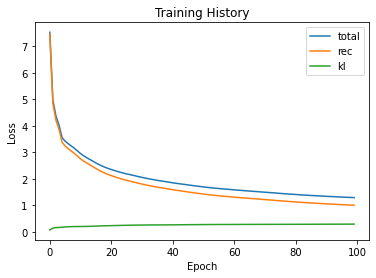

In [16]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec","kl"], loc="upper right")
plt.show()

## Testing

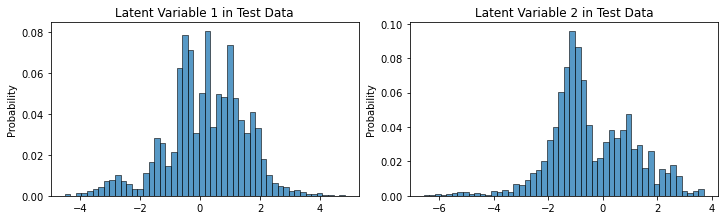

In [17]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1} in Test Data")

In [18]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_num, loss_cat = get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Numerical Variable Loss: 8.096626281738281
Categorical Variable Loss: 0.8928425908088684


In [19]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:  
    # Handle case where are categorical variables
    results_num = scaler_test.inverse_transform(results[0])
    test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for i, x in enumerate(results[1]):
        result = np.argmax(x, axis=1) + 1
        results_df[f"{i}"] = result
    current = CAT_IDX

    # Argmax for each categorical variable the test data
    for i, x in enumerate(CAT_LENGTHS):
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{i}"] = test_data_cat
        current += x
else:
    # Handle case where there are no categorical variables
    results_num = scaler_test.inverse_transform(results)
    test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

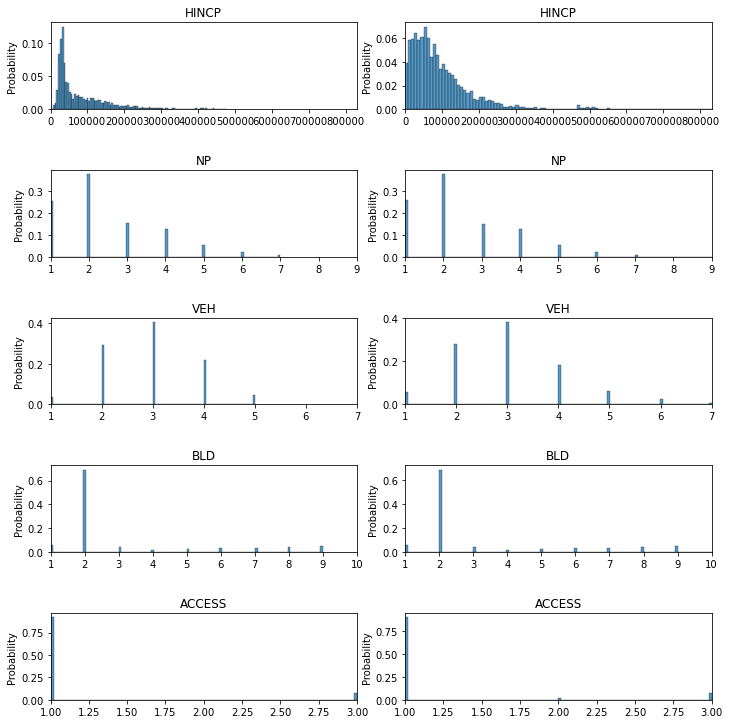

In [20]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [21]:
start_time = time.time()

In [22]:
# How many synthetic households to generate
POP_SIZE = 2848396  # Number of hh in WA

# Generate random normal sample to represent each latent variable, for each row (different hh per row)
inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

# Generate households; each hh has unique latent input
results = vae.decoder.predict(inputs)

In [23]:
print(f"--- {time.time() - start_time} seconds ---")

--- 58.05983328819275 seconds ---


In [24]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:  
    # Handle case where are categorical variables
    results_num = scaler_test.inverse_transform(results[0])
    test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for i, x in enumerate(results[1]):
        result = np.argmax(x, axis=1) + 1
        results_df[f"{i}"] = result

    # Argmax for each categorical variable the test data
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{i}"] = test_data_cat
        current += x
else:
    # Handle case where there are no categorical variables
    results_num = scaler_test.inverse_transform(results)
    test_data_num = scaler_test.inverse_transform(test_data)
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

# In the PUMS data, VEH is indexed from 0 (sensibly). However we have just added 1 to all cat vars, so remove it
results_df['VEH'] = results_df['VEH'] - 1

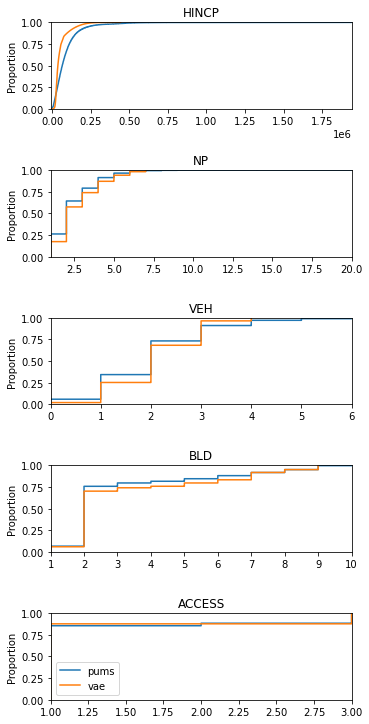

In [25]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=results_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)
    plt.legend(labels=['pums','vae'])

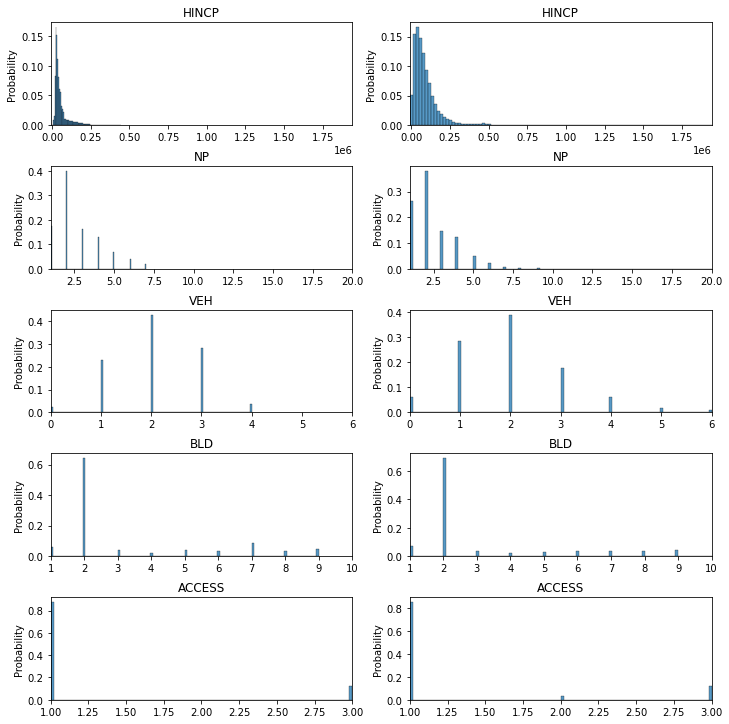

In [26]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=2, w_pad=2)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(pums_data[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

In [27]:
# Save the synthesized households
results_df.to_csv('data/synthetic_populations/wa_households.csv', index=False)
results_df

,HINCP,NP,VEH,BLD,ACCESS
0,35168.074219,3,3,2,3
1,28004.369141,1,1,2,1
2,121230.664062,4,3,2,1
3,37005.187500,1,1,2,1
4,12162.037109,6,3,2,1
...,...,...,...,...,...
2848391,30911.291016,2,3,1,1
2848392,59252.535156,3,3,2,1
2848393,24070.814453,3,3,2,1
2848394,45905.445312,2,2,2,1
